# ENSO composites

## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xarray as xr
import tqdm
import pathlib
import cmocean
import os
import copy

# Import custom modules
import src.utils

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Load data

### $T$, $h$

In [2]:
## open data
Th = src.utils.load_cesm_indices()

## rename indices for convenience
Th = Th.rename(
    {
        "north_tropical_atlantic": "natl",
        "atlantic_nino": "nino_atl",
        "tropical_indian_ocean": "iobm",
        "indian_ocean_dipole": "iod",
        "north_pacific_meridional_mode": "npmm",
        "south_pacific_meridional_mode": "spmm",
    }
)

## load ELI and tropical sst data
eli = xr.open_dataset(pathlib.Path(DATA_FP, "cesm/eli.nc"))
trop_sst = xr.open_dataset(pathlib.Path(DATA_FP, "cesm/trop_sst.nc"))
Th = xr.merge([Th, eli, trop_sst])

### Spatial data

In [3]:
## load spatial data
CONS_DIR = pathlib.Path(DATA_FP, "cesm", "consolidated")
forced = xr.open_dataset(CONS_DIR / "forced.nc")
anom = xr.open_dataset(CONS_DIR / "anom.nc")

## add T,h information
for n in ["T_3", "T_34", "T_4", "eli_05", "h", "h_w", "trop_sst_05"]:
    anom[n] = Th[n]

## get "total" sst and precip
for n in ["sst", "pr"]:
    anom[f"{n}_total"] = forced[n] + anom[n]

### Preprocess

In [4]:
## split into early/late periods
t_early = dict(time=slice("1851", "1880"))
# t_late = dict(time=slice("1990", "2020"))
t_late = dict(time=slice("2071", "2100"))

## split surface data
anom_early = anom.sel(t_early)
anom_late = anom.sel(t_late)

## Composite

### Funcs

In [5]:
def get_composite(idx, data, peak_month, q=0.95, is_warm=True):
    """
    Get hovmoller composite based on specified:
    - data: used to compute index/make composite
    - peak_month: month to center composite on
    - q: quantile threshold for composite
    """

    ## handle warm/cold case
    if is_warm:
        kwargs = dict(q=q, check_cutoff=lambda x, cut: x > cut)
    else:
        kwargs = dict(q=1 - q, check_cutoff=lambda x, cut: x < cut)

    ## kwargs for composite
    kwargs = dict(kwargs, peak_month=peak_month, idx=idx, data=data)

    ## composite of projected data
    comp_proj = src.utils.make_composite(**kwargs)

    return comp_proj


def get_spatial_composite(data, **composite_kwargs):
    """
    Get spatial composite
    """

    ## pull out components
    components, scores = src.utils.split_components(data)

    ## get projected composite
    comp_proj = get_composite(data=scores, **composite_kwargs)

    ## reconstruct spatial fields
    comp = reconstruct_helper(comp_proj, components, func=lambda x: x).drop_vars("mode")

    ## reconstruct relative SST
    comp["sst_rel"] = comp["sst_total"] - comp["trop_sst_05"]

    return comp


def reconstruct_helper(composite, components, func):
    """reconstruction helper function for composite"""

    ## copy to hold reconstructed results
    composite_recon = copy.deepcopy(composite)

    ## reconstruct anomalies
    for c in list(components):
        composite_recon[c] = src.utils.reconstruct_fn(
            components=components[c],
            scores=composite[c],
            fn=func,
        )

    ## check for "total" fields
    for c in list(composite):
        if "_total" in c:
            n = c[:-6]
            composite_recon[c] = src.utils.reconstruct_fn(
                components=components[n],
                scores=composite[c],
                fn=func,
            )

    return composite_recon


def get_spatial_clim(forced, lags, peak_month):
    """get climatologies of spatial variables"""

    ## reconstruct monthly climatology for period
    clim = src.utils.reconstruct_clim(data=forced)

    ## convert to lag coordinates
    months = 1 + np.mod(lags + peak_month - 1, 12)
    clim_comp = xr.concat(
        [clim.sel(month=m).drop_vars("month") for m in months],
        dim=lags,
    )

    return clim_comp


def add_advection_terms(comp, comp_clim, delta=5, H0=None):
    """add advection terms to composite"""

    ## copy composite
    comp_ = copy.deepcopy(comp)

    ## zonal velocity
    comp_["adv_uprime_Tbar"] = -src.utils.get_udTdx(u=comp["u"], T=comp_clim["T"])
    comp_["adv_ubar_Tprime"] = -src.utils.get_udTdx(T=comp["T"], u=comp_clim["u"])

    ## vertical velocity
    comp_["adv_wprime_Tbar"] = src.utils.get_wdTdz(w=comp["w"], T=comp_clim["T"])
    comp_["adv_wbar_Tprime"] = src.utils.get_wdTdz(T=comp["T"], w=comp_clim["w"])

    ## integrate over mixed layer
    for v in list(comp_):
        if "adv" in v:
            comp_[f"{v}_ml"] = src.utils.get_ml_avg(
                comp_[v],
                Hm=comp_clim["mld"],
                delta=delta,
                H0=H0,
            )

    ## add together zonal adv and thermocline feedbacks
    comp_["Th_zaf_ml"] = comp_["adv_wbar_Tprime_ml"] + comp_["adv_uprime_Tbar_ml"]

    return comp_


def get_T_ml_tendency(T, mld, delta=5, H0=None):
    """compute mixed-layer temperature tendency"""

    ## integrate over mixed layer
    T_ml = src.utils.get_ml_avg(T, Hm=mld, delta=delta, H0=H0)

    ## compute tendency
    return T_ml.differentiate("lag")


def get_spatial_composite_wrapper(
    data,
    forced_scores,
    peak_month,
    delta=5,
    H0=None,
    **composite_kwargs,
):
    """
    Get spatial composite
    """

    ## get spatial composite of anomalies
    composite = get_spatial_composite(
        data=data,
        peak_month=peak_month,
        **composite_kwargs,
    )

    ## get background state
    comp_clim = get_spatial_clim(
        forced=forced_scores,
        lags=composite.lag,
        peak_month=peak_month,
    )

    ## add advection terms
    composite = add_advection_terms(
        comp=composite, comp_clim=comp_clim, delta=delta, H0=H0
    )

    ## add mixed-layer temperature tendency
    composite["ddt_T"] = get_T_ml_tendency(
        composite["T"],
        mld=comp_clim["mld"],
        delta=delta,
        H0=H0,
    )

    ## add SST tendency
    composite["ddt_sst"] = composite["sst"].differentiate("lag")

    ## get NHF in units of K/mo
    sec_per_mo = 8.64e4 * 30
    rho = 1.02e3
    Cp = 4.2e3
    H = comp_clim["mld"]
    # H = 50
    composite["Q"] = composite["nhf"] * sec_per_mo / (rho * Cp * H)

    return composite

### Compute

In [6]:
## specify what variable to use
VARNAME = "T_34"

## specify shared args
kwargs = dict(
    peak_month=12,
    q=0.95,
    is_warm=True,
    delta=10,
    H0=60,
)

## do the compute
comp_early = get_spatial_composite_wrapper(
    idx=anom_early[VARNAME],
    data=anom_early,
    forced_scores=forced.sel(t_early),
    **kwargs,
)
comp_late = get_spatial_composite_wrapper(
    idx=anom_late[VARNAME],
    data=anom_late,
    forced_scores=forced.sel(t_late),
    **kwargs,
)

## hovmoller version
merimean = lambda x: x.sel(latitude=slice(-5, 5)).mean("latitude")
hov_comp_early = merimean(comp_early).transpose("lag", ...)
hov_comp_late = merimean(comp_late).transpose("lag", ...)

### Plot

In [42]:
def plot_cycle_hov_lagged(
    ax,
    data,
    amp,
    is_filled=True,
    xticks=[190, 240],
    lat_bound=5,
    nlev=5,
    cmap="cmo.balance",
    levels=None,
):
    """plot data on ax object"""

    ## set levels if not specified
    if levels is None:
        levels = src.utils.make_cb_range(amp, amp / nlev)

    ## specify shared kwargs
    shared_kwargs = dict(levels=levels, extend="both")

    ## specify kwargs
    if is_filled:
        plot_fn = ax.contourf
        kwargs = dict(cmap=cmap)

    else:
        plot_fn = ax.contour
        kwargs = dict(colors="k", linewidths=0.8)

    ## average over latitudes (if necessary)
    if "latitude" in data.coords:
        plot_data = merimean(data, lat_bound=lat_bound)
    else:
        plot_data = data

    ## do the plotting
    cp = plot_fn(
        plot_data.longitude,
        plot_data.lag,
        plot_data.transpose("lag", "longitude"),
        **kwargs,
        **shared_kwargs,
    )

    ## format ax object
    kwargs = dict(c="w", ls="--", lw=0.8, alpha=0.5)
    ax.set_xlim([145, 280])
    ax.set_xlabel("Lon")
    ax.set_xticks(xticks)
    for tick in xticks:
        ax.axvline(tick, **kwargs)
    ax.axhline(0, **kwargs)

    return cp


def format_hov_axs(axs, peak_mon):
    """format hov axs"""

    ## label
    font_kwargs = dict(size=10)
    axs[0].set_title("Early", **font_kwargs)
    axs[1].set_title("Late", **font_kwargs)
    axs[2].set_title("Difference (scaled)", **font_kwargs)
    for ax in axs:
        ax.set_yticks([])

    src.utils.label_hov_yaxis(axs[0], peak_mon=peak_mon)

    return axs


def plot_eli_on_axs(axs, x0, x1, name="eli_05"):
    """plot ELI boundary on hovmoller axs"""

    ## plot ELI
    axs[0].plot(x0[name], x0.lag, c="magenta")
    axs[1].plot(x1[name], x1.lag, c="magenta", ls="--")
    axs[2].plot(x0[name], x0.lag, c="magenta", ls="-")
    axs[2].plot(x1[name], x1.lag, c="magenta", ls="--")

    return


def plot_comp_on_axs(
    axs,
    x0,
    x1,
    name,
    amp,
    peak_month,
    amp_diff=None,
    nlev=5,
    **kwargs,
):
    """plot composite on axs objects"""

    ## handle amp_diff=None
    if amp_diff is None:
        amp_diff = amp / 2

    ## loop thru: x0, x1, (x1-x0)
    for ax, x in zip(axs, [x0, x1, (amp / amp_diff) * (x1 - x0)]):

        ## Plot data and suppress y-axis plot
        cf = plot_cycle_hov_lagged(ax=ax, data=x[name], amp=amp, nlev=nlev, **kwargs)

    ## format/label
    format_hov_axs(axs, peak_mon=peak_month)

    return cf

#### Shared args for hovmoller

In [43]:
hov_kwargs = dict(
    x0=hov_comp_early,
    x1=hov_comp_late,
    peak_month=kwargs["peak_month"],
)

#### SST, SSH

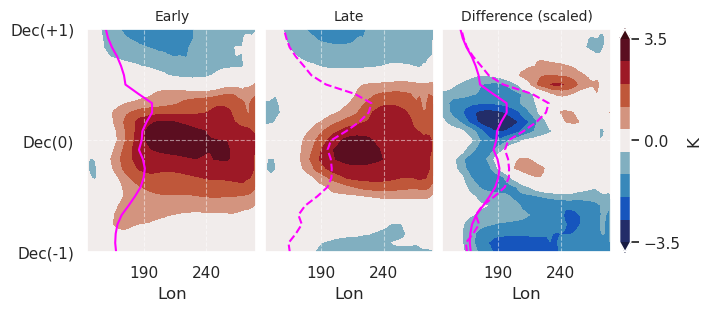

In [44]:
## set up plot
fig, axs = plt.subplots(1, 3, figsize=(7, 3), layout="constrained")

## plot data
cf = plot_comp_on_axs(axs, name="sst", amp=3.5, **hov_kwargs)

## label
cb = fig.colorbar(cf, ax=axs[2], ticks=[-3.5, 0, 3.5], label="K")

## plot ELI
plot_eli_on_axs(axs, x0=comp_early, x1=comp_late)

plt.show()

#### Precip, relative ELI

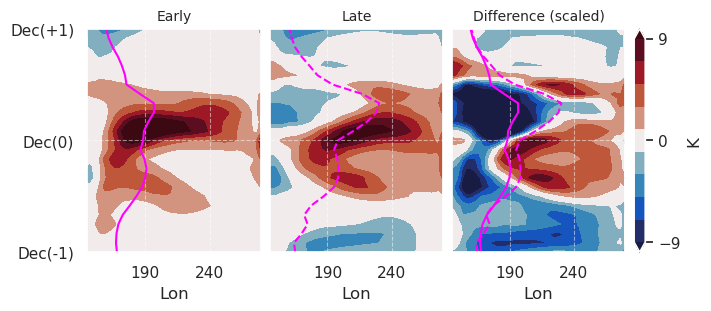

In [45]:
## set up plot
fig, axs = plt.subplots(1, 3, figsize=(7, 3), layout="constrained")

## plot data
cf = plot_comp_on_axs(axs, name="pr", amp=1e-4, **hov_kwargs)

## label
cb = fig.colorbar(cf, ax=axs[2], ticks=[-9, 0, 9], label="K")

## plot ELI
plot_eli_on_axs(axs, x0=comp_early, x1=comp_late)

plt.show()

#### Total precip, relative SST

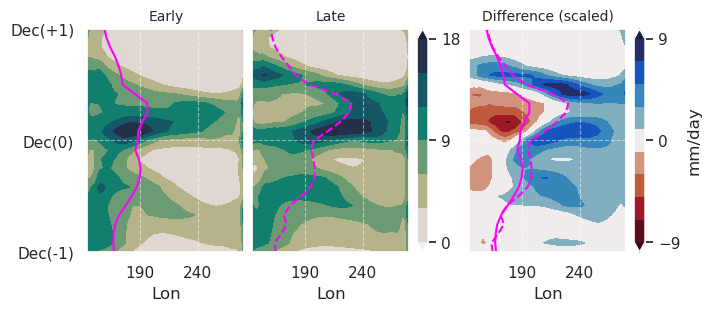

In [49]:
## shared args
pr_kwargs = dict(levels=np.arange(0, 21, 3), cmap="cmo.rain", amp=1e-4)

## set up plot
fig, axs = plt.subplots(1, 3, figsize=(7, 3), layout="constrained")

## plot data
cf0 = plot_cycle_hov_lagged(
    ax=axs[0],
    data=8.6e4 * hov_comp_early["pr_total"],
    **pr_kwargs,
)

cf1 = plot_cycle_hov_lagged(
    ax=axs[1],
    data=8.6e4 * hov_comp_late["pr_total"],
    **pr_kwargs,
)

cf_diff = plot_cycle_hov_lagged(
    ax=axs[2],
    data=8.6e4 * (hov_comp_late - hov_comp_early)["pr_total"],
    cmap="cmo.balance_r",
    levels=src.utils.make_cb_range(9, 1.8),
    amp=1e-4,
)

## label
cb = fig.colorbar(cf1, ax=axs[1], ticks=[0, 9, 18])
cb = fig.colorbar(cf_diff, ax=axs[2], ticks=[-9, 0, 9], label="mm/day")
format_hov_axs(axs, peak_mon=hov_kwargs["peak_month"])

## plot ELI
plot_eli_on_axs(axs, x0=comp_early, x1=comp_late)

plt.show()